# Online Learning Success Analysis
## Final Project Notebook

### Load Data

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

students = pd.read_csv('students.csv')
logins = pd.read_csv('logins.csv', parse_dates=['timestamp'])
submissions = pd.read_csv('submissions.csv', parse_dates=['timestamp'])
discussions = pd.read_csv('discussions.csv', parse_dates=['timestamp'])
grades = pd.read_csv('grades.csv')

# Count how many times each student logged in
login_counts = logins.groupby('student_id').size().reset_index(name='total_logins')

# Calculate average assignment score and total late submissions
submission_metrics = submissions.groupby('student_id').agg({
    'score': 'mean',
    'late_flag': 'sum'
}).reset_index().rename(columns={'score': 'avg_assignment_score', 'late_flag': 'total_late_submissions'})

# Sum up total words written and replies made in discussions
discussion_metrics = discussions.groupby('student_id').agg({
    'word_count': 'sum',
    'reply_count': 'sum'
}).reset_index().rename(columns={'word_count': 'total_word_count', 'reply_count': 'total_replies'})

# Student demographics table
df_final = students.merge(grades, on='student_id', how='left')

# Merge in our aggregated metrics
df_final = df_final.merge(login_counts, on='student_id', how='left')
df_final = df_final.merge(submission_metrics, on='student_id', how='left')
df_final = df_final.merge(discussion_metrics, on='student_id', how='left')

# Fill NaN values with 0
df_final = df_final.fillna(0)

# Display the result
print("Final Dataset Shape:", df_final.shape)
df_final.head()

Final Dataset Shape: (50, 11)


,student_id,age,major,prior_online_experience,weekly_study_hours,final_grade,total_logins,avg_assignment_score,total_late_submissions,total_word_count,total_replies
0,S001,24,Psychology,0,16,85,11,68.2,0,631,22
1,S002,37,Biology,0,15,90,20,87.4,0,523,17
2,S003,46,Biology,0,4,95,17,81.4,2,1185,55
3,S004,32,Business,Medium,2,75,37,80.6,2,704,24
4,S005,28,Psychology,0,6,92,25,70.4,0,1709,37


### Second Data Source
Derived from National Survey of Student Engagement (NSSE) & NCES Data

In [10]:
benchmark_data = {
    'major': ['Biology', 'Psychology', 'Business', 'Education', 'Computer Science'],
    'national_avg_study_hours': [18.5, 14.0, 14.0, 12.0, 19.5],  # STEM majors typically study more
    'national_avg_gpa': [2.78, 3.25, 3.20, 3.36, 3.10]           # STEM grades are often lower (deflation)
}

df_benchmarks = pd.DataFrame(benchmark_data)

# Merge this national data into the student master list
df_enriched = df_final.merge(df_benchmarks, on='major', how='left')

# "Effort Gap": How much more/less is this student studying compared to the national average?
df_enriched['study_hours_vs_national'] = df_enriched['weekly_study_hours'] - df_enriched['national_avg_study_hours']

print("External Data Integrated. New Columns:", df_enriched.columns.tolist())
df_enriched.head()

External Data Integrated. New Columns: ['student_id', 'age', 'major', 'prior_online_experience', 'weekly_study_hours', 'final_grade', 'total_logins', 'avg_assignment_score', 'total_late_submissions', 'total_word_count', 'total_replies', 'national_avg_study_hours', 'national_avg_gpa', 'study_hours_vs_national']


,student_id,age,major,prior_online_experience,weekly_study_hours,final_grade,total_logins,avg_assignment_score,total_late_submissions,total_word_count,total_replies,national_avg_study_hours,national_avg_gpa,study_hours_vs_national
0,S001,24,Psychology,0,16,85,11,68.2,0,631,22,14.0,3.25,2.0
1,S002,37,Biology,0,15,90,20,87.4,0,523,17,18.5,2.78,-3.5
2,S003,46,Biology,0,4,95,17,81.4,2,1185,55,18.5,2.78,-14.5
3,S004,32,Business,Medium,2,75,37,80.6,2,704,24,14.0,3.20,-12.0
4,S005,28,Psychology,0,6,92,25,70.4,0,1709,37,14.0,3.25,-8.0


### Visualize the Insight
Do students who study MORE than the national average actually get better grades?

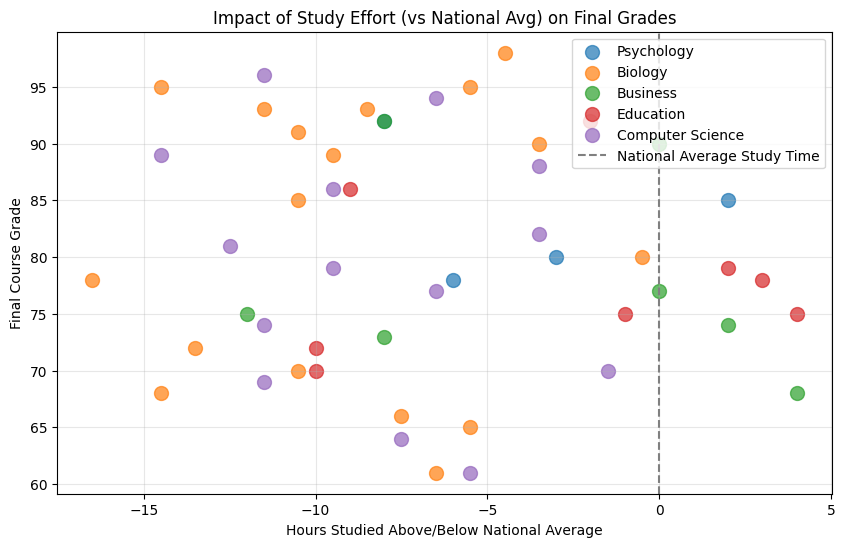

Statistical Correlation between Extra Study Effort and Grades: -0.0799


In [11]:
plt.figure(figsize=(10, 6))

# Scatter plot: x-axis is "Effort Gap", y-axis is "Final Grade"
# Color points by Major to show diversity
for major in df_enriched['major'].unique():
    subset = df_enriched[df_enriched['major'] == major]
    plt.scatter(subset['study_hours_vs_national'], subset['final_grade'], label=major, alpha=0.7, s=100)

plt.axvline(0, color='gray', linestyle='--', label='National Average Study Time')
plt.title("Impact of Study Effort (vs National Avg) on Final Grades")
plt.xlabel("Hours Studied Above/Below National Average")
plt.ylabel("Final Course Grade")
plt.legend()
plt.grid(True, alpha=0.3)

plt.savefig('study_effort_analysis.png')
plt.show()

# Calculate correlation between "Extra Effort" and "Final Grade"
correlation = df_enriched['study_hours_vs_national'].corr(df_enriched['final_grade'])
print(f"Statistical Correlation between Extra Study Effort and Grades: {correlation:.4f}")

### Descriptive Graphic
Plotting a histogram to see the distribution of Final Grades, validates that the grade data looks normal (bell curve) and isn't corrupted.

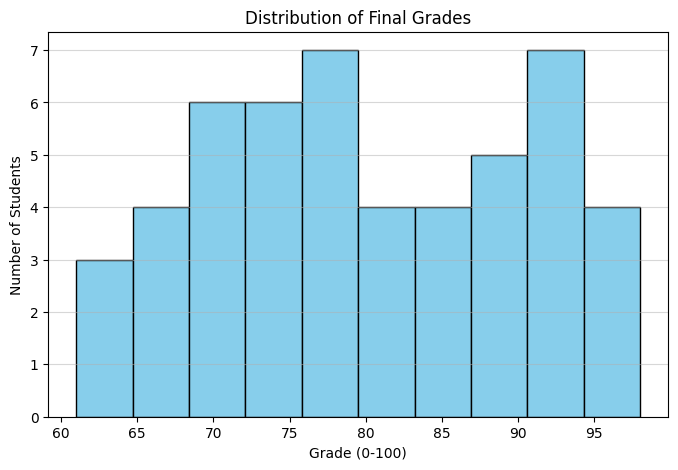

In [13]:
plt.figure(figsize=(8, 5))
plt.hist(df_enriched['final_grade'], bins=10, color='skyblue', edgecolor='black')
plt.title("Distribution of Final Grades")
plt.xlabel("Grade (0-100)")
plt.ylabel("Number of Students")
plt.grid(axis='y', alpha=0.5)
plt.savefig('grade_distribution.png')
plt.show()

### New Feature Implementation
Using scikit-learn to create a Decision Tree Regressor, can we predict a student's final grade based on their activity?

Model Trained! Average Error in Prediction: 9.29 points


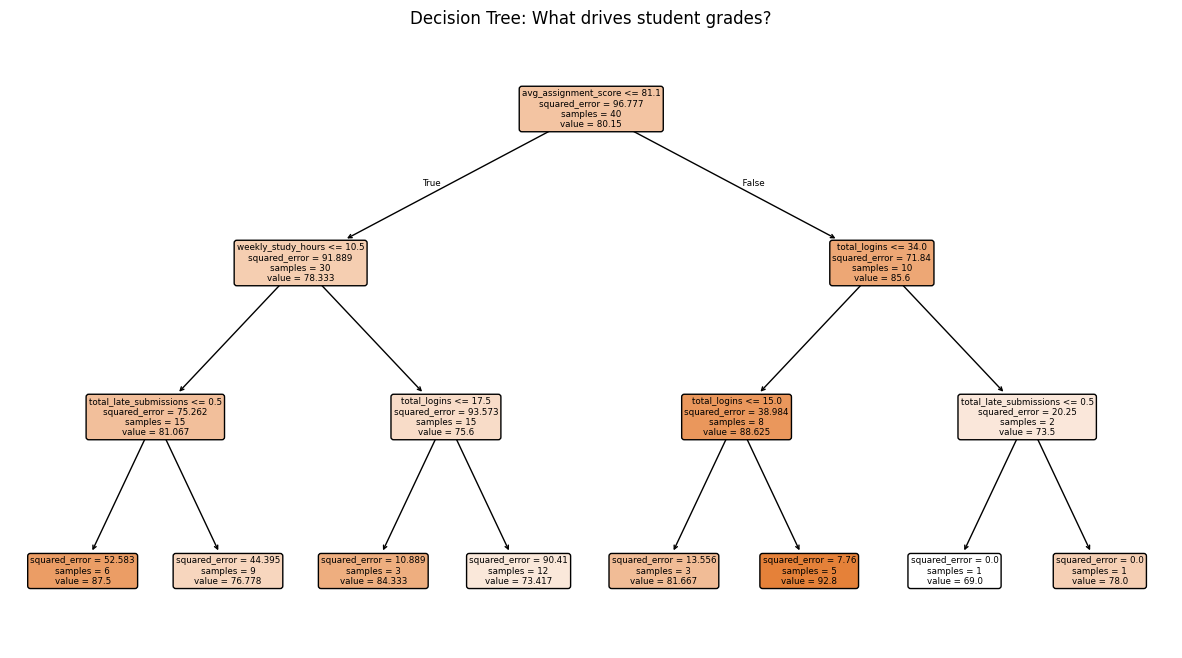

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import plot_tree

# 1. Prepare the data
features = ['total_logins', 'weekly_study_hours', 'avg_assignment_score', 'total_late_submissions']
X = df_enriched[features]
y = df_enriched['final_grade']

# 2. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize and Train the Model
model = DecisionTreeRegressor(max_depth=3, random_state=42)
model.fit(X_train, y_train)

# 4. Test the Model
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)

print(f"Model Trained! Average Error in Prediction: {mae:.2f} points")

# 5. Visualize the Decision Tree
plt.figure(figsize=(15, 8))
plot_tree(model, feature_names=features, filled=True, rounded=True)
plt.title("Decision Tree: What drives student grades?")
plt.savefig('decision_tree.png')
plt.show()